In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Getting Data

Contains the following 6 fields:

* target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)

In [3]:
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", names = columns)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.shape

(1600000, 6)

In [6]:
len(df['user'].unique())

659775

<Axes: title={'center': 'Ratio of sentiment label'}, ylabel='Counts'>

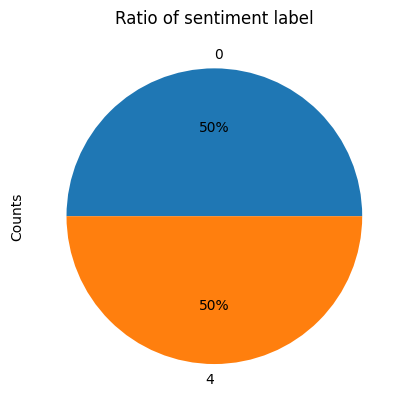

In [9]:
df.groupby(['sentiment']).size().plot(kind='pie',ylabel='Counts', autopct='%1.0f%%', title='Ratio of sentiment label')

There are two type of sentiment - 0 for negative and 4 for positive in this dataset.

### Weighted sampling the data

In [10]:
dataText = df.groupby('sentiment')[['sentiment', 'text']].sample(n=70000, random_state=1)
dataText.reset_index(inplace=True)

In [11]:
dataText

,index,sentiment,text
0,670935,0,"@TheRealScarab PA system bugs are a bummer, so..."
1,649589,0,oh daaamnnn! the firemen ball's on the 14th an...
2,2028,0,"I don't want to be cold in April, but I am"
3,669856,0,@JaredOngie haha its too cold down here bt ot...
4,458897,0,Upset I can't find my CHI!
...,...,...,...
139995,860453,4,@lynnnein Lmao I think I'll always have growin...
139996,1070764,4,"@marinavorobyev no doubt, we have to support e..."
139997,978520,4,"now on, gonna have a word of the day todays w..."
139998,1502159,4,@LolaHedoOnline awful and sweaty are two of my...


<Axes: xlabel='sentiment'>

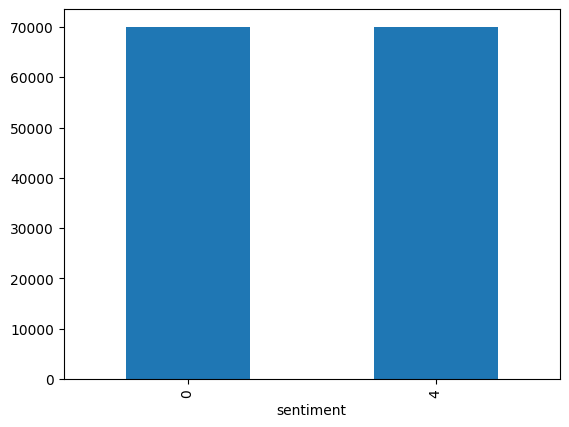

In [10]:
dataText.groupby(['sentiment']).size().plot(kind='bar')

## Preprocessing text

#### Checking for null values

In [11]:
dataText.isnull().any()

index        False
sentiment    False
text         False
dtype: bool

#### WordCloud

In [12]:
# !pip install wordcloud

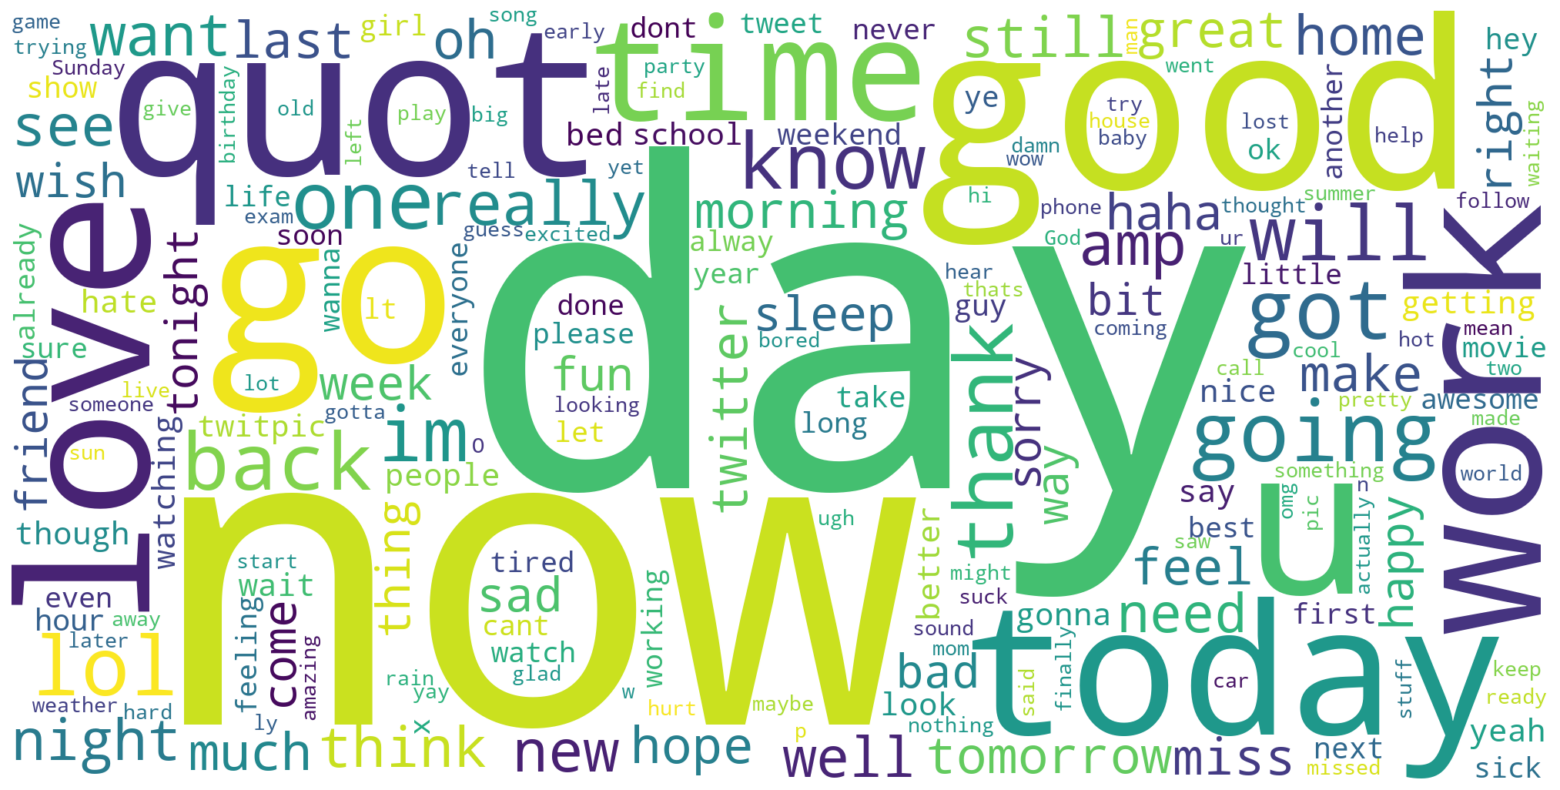

In [14]:
from wordcloud import WordCloud
plt.figure(figsize=(20,10))
#Creating the text variable
textBeforePre = " ".join(cat for cat in dataText.text)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white', width=2000, height=1000).generate(textBeforePre)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Language checking

Using the library langdetect to check for languages other than English and removing those rows from the data. langDetect checks the most frequent phrases, such as "like to", to see if they exist and marks them with the corresponding language.

In [15]:
!pip install langdetect

     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     ------------------------------------- 981.5/981.5 kB 31.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993254 sha256=0052c5cd2287c29366b25c7d7a15ddffaf5ee542dd9fa9a0ee958fcbf0454c83
  Stored in directory: c:\users\kevin zhu\appdata\local\pip\cache\wheels\13\c7\b0\79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import langdetect

languages_langdetect = []

# the try except blook because there is some tweets contain links
for line in dataText['text']:
    try:
        result = langdetect.detect_langs(line)
        result = str(result[0])[:2]
    except:
        result = 'unknown'
    
    finally:
        languages_langdetect.append(result)

dataText['languages']=languages_langdetect

dataText['languages'].unique()

In [12]:
for l in dataText['languages'].unique():
        if l != 'en':
                dataText.drop(dataText[(dataText['languages']==l)].index, axis=0, inplace=True)

In [63]:
dataText['target'] = dataText['sentiment'].apply(lambda x : x if x==0 else 1)

<Axes: xlabel='target'>

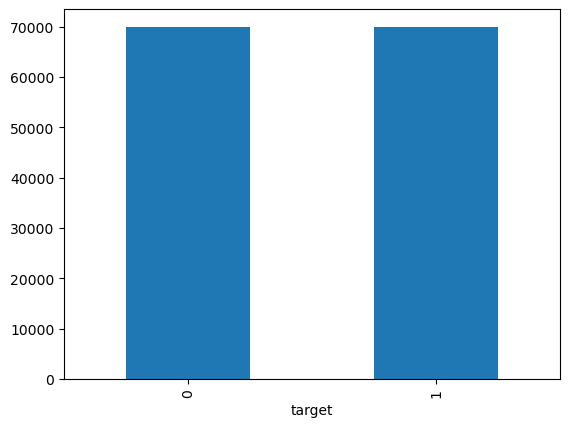

In [64]:
dataText.groupby(['target']).size().plot(kind='bar')

In [65]:
dataText.shape

(140000, 4)

### Preprocessing Methods

We have taken the following data preprocessing steps into consideration:

* **Lower Casing**: Each text is converted to lowercase.
* **Removing URLs**: Links starting with 'http' or 'https' or 'www' are replaced by space.
* **Removing Usernames**: Replace @Usernames with word space.
* **Replacing Emojies** : replace all emojis from the emoji shortcodes [eg: 👍 to 'thumbs up']
* **Replacing the chat words and numbers** : replace all chat abrevations from the normal words [eg: lol to 'laugh out loud' and 1 to one]
* **Replacing Contractions**: Replacing contractions with their meanings. [eg: "can't" to 'can not']
* **Removing Puntuations**: Replacing characters other than Digits, Alphabets and pre-defined Symbols with a space.
* **Lemmatization** and replacing **Consecutive letters**: lemmatizing the words and replacing 3 or more consecutive letters are replaced by 1 letters. [eg: 'damnnnnnn' to 'damn']
* **Replacing mistake of spellings** : correcting the spelling mistakes. [eg. caar to car]
* **Removing stopwords** : words which are not meaningful to the sentiment of the sentence.

In [16]:
import nltk
from num2words import num2words 


chatSlangDf = pd.read_csv("chat_slang.csv")
chatSlangDf = chatSlangDf[['acronym', 'expansion']]
chatSlangDf.loc[len(chatSlangDf.index)] = ['2an', "to an"]
display(chatSlangDf.head())
chatSlangDf

def replace_chat_words(word):
    normal_word = chatSlangDf[chatSlangDf['acronym'].isin([word])]['expansion'].values
    if len(normal_word):
        if word == "lol":
            return normal_word[1]
        else:
            return normal_word[0]
    elif word.isnumeric():
        return num2words(word)
    else:
        return word


,acronym,expansion
0,2day,today
1,2m2h,too much too handle
2,2moro,tomorrow
3,2nite,tonight
4,4eae,for ever and ever


In [17]:
import string
string.punctuation
import re
import spacy
from spacy.lang.en import stop_words as spacy_stopwords
import contractions
import emoji
from autocorrect import Speller


spell = Speller(lang='en')
stop_words = spacy_stopwords.STOP_WORDS
nlp = spacy.load('en_core_web_lg')

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = r'@[^\s]+'
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1"

def preprocessingText(text):
    text = text.lower()

    # Removing all URls
    text = re.sub(urlPattern,'',text)
    
    # Removing all usernames
    text = re.sub(userPattern,'', text)
    
    # Replace all emojis from the emoji shortcodes
    text = " ".join([" ".join(emoji.demojize(x)[1:-1].split("_")) if emoji.is_emoji(x) else x for x in text.split()])

    # Replacing the chat words and numbers
    text = " ".join([replace_chat_words(word) if nltk.pos_tag([word])[0][1] in ['NN', "CD"] else word for word in text.split()])


    # Replacing contractions
    text = contractions.fix(text)

    # Remove non-alphanumeric and symbols (puntuations)
    text = "".join([i for i in text if i not in string.punctuation])

    # Replace 3 or more consecutive letters by 1 letter and lemmatizing the words
    text = " ".join([re.sub(sequencePattern, seqReplacePattern, str(token)) if token.pos_ in ["PROPN", 'NOUN'] else token.lemma_ for token in nlp(text)])

    # Replacing mistake of spellings
    text = spell(text)

    # Removing stopwords
    text = " ".join([x for x in text.split() if str(x.lower()) not in stop_words])

    # removing short words
    # text = ' '.join([w for w in text if len(w) > 2])

    # Remove whitespces
    text = text.strip()

    return text


In [18]:
dataText['processedText'] = dataText['text'].apply(preprocessingText)

In [19]:
dataText

,index,sentiment,text,languages,target,processedText
0,670935,0,"@TheRealScarab PA system bugs are a bummer, so...",en,0,personal assistant system bugs summer sorry
1,649589,0,oh daaamnnn! the firemen ball's on the 14th an...,en,0,overhead damn firemen ball 14th cannes handsom...
2,2028,0,"I don't want to be cold in April, but I am",en,0,want cold april
3,669856,0,@JaredOngie haha its too cold down here bt ot...,en,0,haha cold instant message fine st extremely bo...
4,458897,0,Upset I can't find my CHI!,en,0,upset find chi
...,...,...,...,...,...,...
139995,860453,4,@lynnnein Lmao I think I'll always have growin...,en,1,laugh ass think grow pains grow
139996,1070764,4,"@marinavorobyev no doubt, we have to support e...",en,1,doubt support
139997,978520,4,"now on, gonna have a word of the day todays w...",en,1,word day todays word hmm apocalypse
139998,1502159,4,@LolaHedoOnline awful and sweaty are two of my...,en,1,awful sweat favorite things lime face


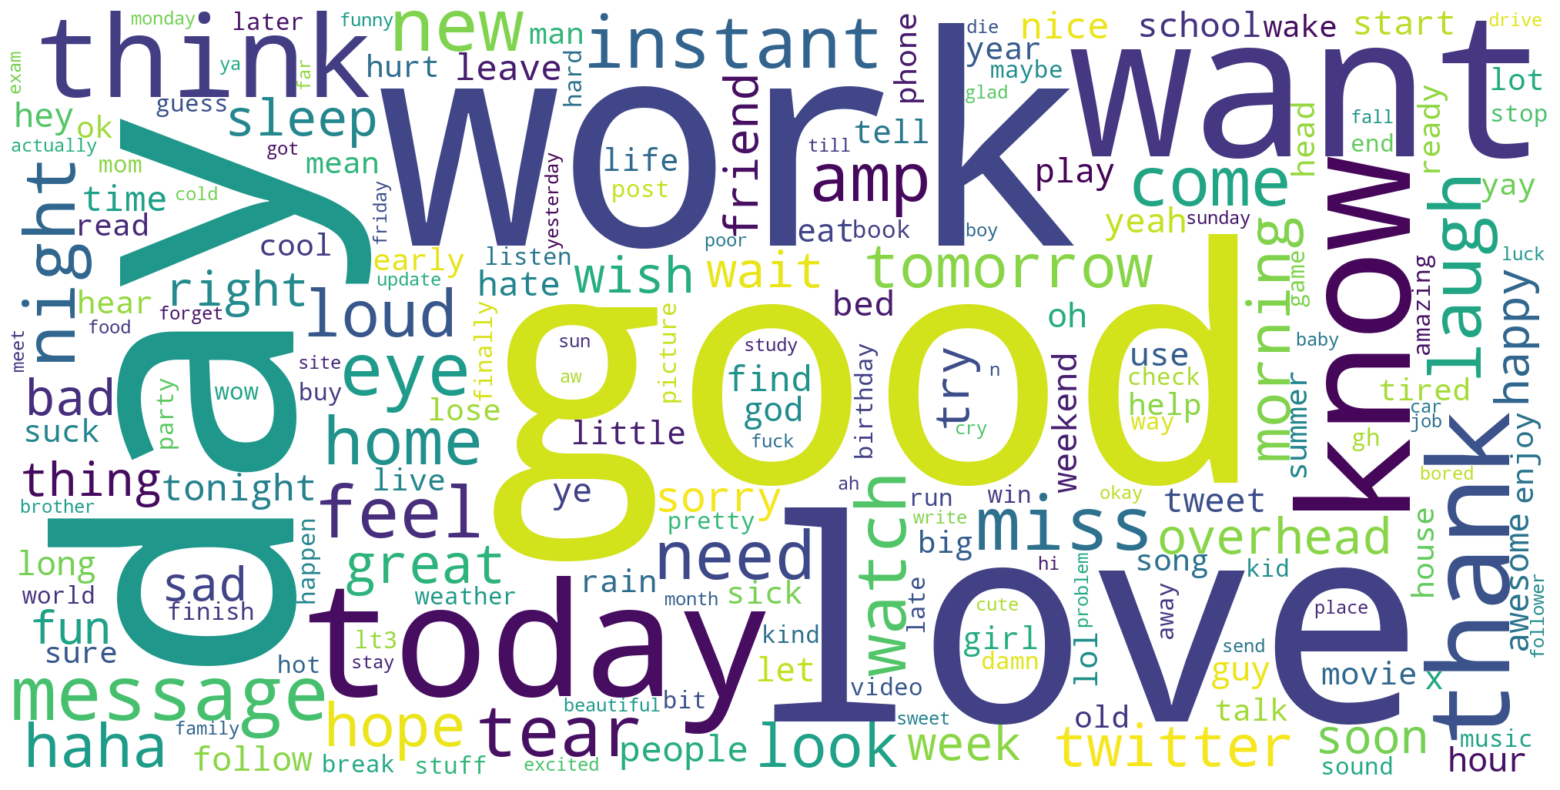

In [20]:
from wordcloud import WordCloud
plt.figure(figsize=(20,10))
#Creating the text variable
textAfterPre = " ".join(cat for cat in dataText['processedText'])
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white', width=2000, height=1000).generate(textAfterPre)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
dataText.to_pickle('preprocessedtext.pkl')

In [20]:
dataPreprocessed = pd.read_pickle("preprocessedtext.pkl")

# Basic customized model approach

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


df_train, df_test, y_train_basic, y_test_basic = train_test_split(dataPreprocessed['processedText'], dataPreprocessed.target, test_size=0.2, random_state=0)

tfidf_vectorizer_train = TfidfVectorizer()
tfidf_vectorizer_train.fit(dataPreprocessed['processedText'])
X_train_basic = tfidf_vectorizer_train.transform(df_train)
X_test_basic = tfidf_vectorizer_train.transform(df_test)

print(X_train_basic.shape)

NameError: name 'dataPreprocessed' is not defined

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Fucntion to calculate the score and confusion matrix to print
def metrixAndScoring(test, pred, fold=0): 
    if fold:
        return [fold, precision_score(test, pred), recall_score(test, pred), f1_score(test, pred), accuracy_score(test, pred), roc_auc_score(test, pred)]
    else:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        fpr, tpr, _ = roc_curve(test, pred)
        roc_auc = auc(fpr, tpr)

        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(test.ravel(), pred.ravel())
        roc_auc = auc(fpr, tpr)
        f, axs = plt.subplots(1,3,figsize=(10,4),sharey=True)
        f.tight_layout()
        plt.subplot(1, 2, 1)
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic curve')
        plt.legend(loc="lower right")
        plt.subplot(1, 2, 2)
        class_names = [0,1]
        # Confusion Matrix Display
        cf_matrix = confusion_matrix(test, pred)
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        s = sns.heatmap(cf_matrix, annot=labels,fmt='')
        s.set_title("Confusion metric")
        plt.show()
        s.set(ylabel='True labels', xlabel='Predicted labels')
        return [precision_score(test, pred), recall_score(test, pred), f1_score(test, pred), accuracy_score(test, pred), roc_auc_score(test, pred)] + group_percentages
        

from sklearn.inspection import permutation_importance

# function to calculate feature importance
def variableImportance(model, X, y, reg):
    plt.figure(figsize=(20,5))
    # plot feature importance
    if reg:
        feat_importances = pd.Series(model.coef_[0], index=X.columns)
        f, axs = plt.subplots(1,2,figsize=(20,5),sharey=True)
        f.tight_layout()
        plt.subplot(1, 2, 1)
        feat_importances.nlargest(50).plot(kind='bar')
        plt.title("Variable predicting class 1 (Target = 1)")
        plt.xlabel("Number of variables")
        plt.ylabel("Score")
        plt.xticks(fontsize=10)
        plt.subplot(1, 2, 2)
        feat_importances.nsmallest(50).plot(kind='bar')
        plt.title("Variable predicting class 0 (Target = 0)")
        plt.xlabel("Number of variables")
        plt.ylabel("Score")
        plt.xticks(fontsize=10)
        plt.show()
    else:
        feat_importances = pd.Series(model.feature_importances_, index=X.columns)
        # plt.bar([x for x in range(len(importance))], importance)
        feat_importances.nlargest(100).plot(kind='bar')
        plt.title("Variable importance with positive effect (Target = 1)")
        plt.xlabel("Number of variables")
        plt.ylabel("Score")
        plt.xticks(fontsize=10)

    
AllScores = []
def fittingModel(name, model, x_train, x_test ,y_train, y_test):
    # fitting the data to the given model
    model.fit(x_train, y_train)
    # displaying the interpretated values
    returnValues = [name]+metrixAndScoring(y_test, model.predict(x_test))
    AllScores.append(returnValues)
    display(pd.DataFrame([[returnValues[1], returnValues[2], returnValues[3], returnValues[4], returnValues[5]]], columns=['Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC Score']).round(2))
    return model

### LogisticRegression

In [2]:
from sklearn.linear_model import LogisticRegression


log_model = fittingModel("LogisticRegression" , LogisticRegression(), X_train_basic, X_test_basic, y_train_basic, y_test_basic )

NameError: name 'fittingModel' is not defined

##### Random Forest

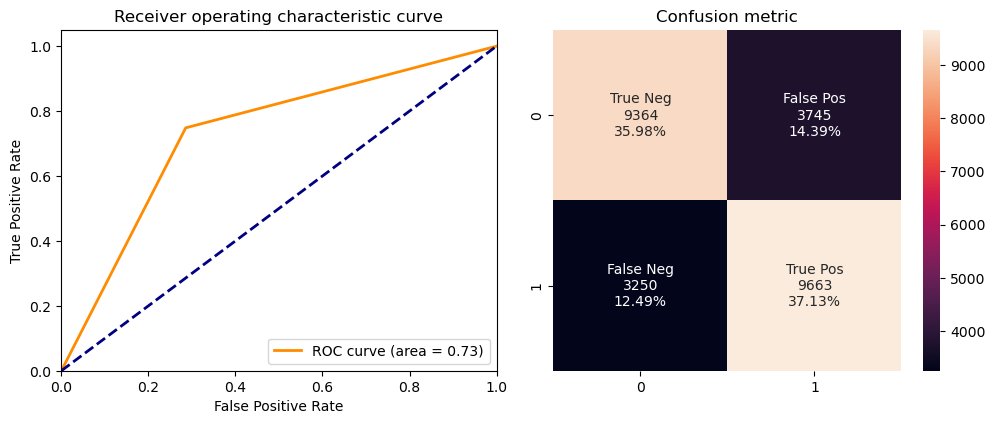

,Precision,Recall,F1,Accuracy,ROC AUC Score
0,0.72,0.75,0.73,0.73,0.73


RandomForestClassifier()

In [26]:
from sklearn.ensemble import RandomForestClassifier


fittingModel("RandomForestClassifier",RandomForestClassifier(), X_train_basic, X_test_basic, y_train_basic, y_test_basic )

##### Boosting with XGBoost

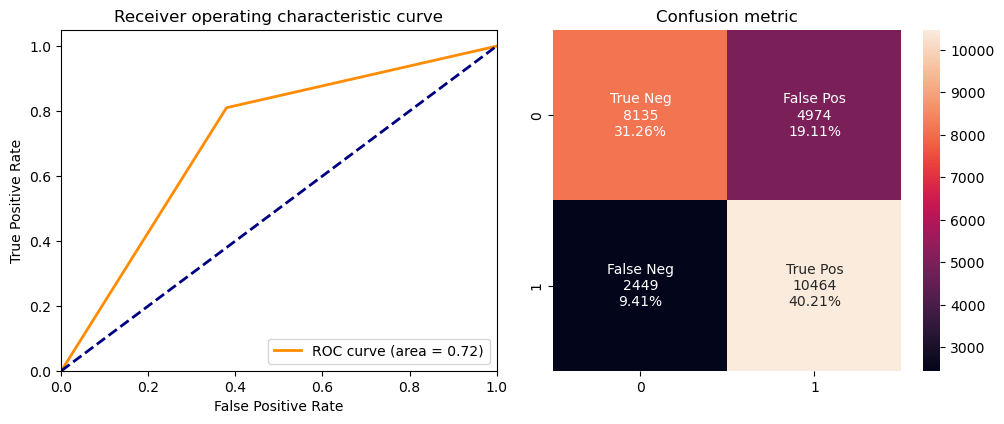

,Precision,Recall,F1,Accuracy,ROC AUC Score
0,0.68,0.81,0.74,0.71,0.72


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [27]:
from xgboost import XGBClassifier


fittingModel("XGBClassifier", XGBClassifier(), X_train_basic, X_test_basic, y_train_basic, y_test_basic)


In [28]:
# from sklearn.neural_network import MLPClassifier


# fittingModel("MLPClassifier", MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2)), X_train_basic, X_test_basic, y_train_basic, y_test_basic)

Text(0.5, 1.0, 'Model Comparison')

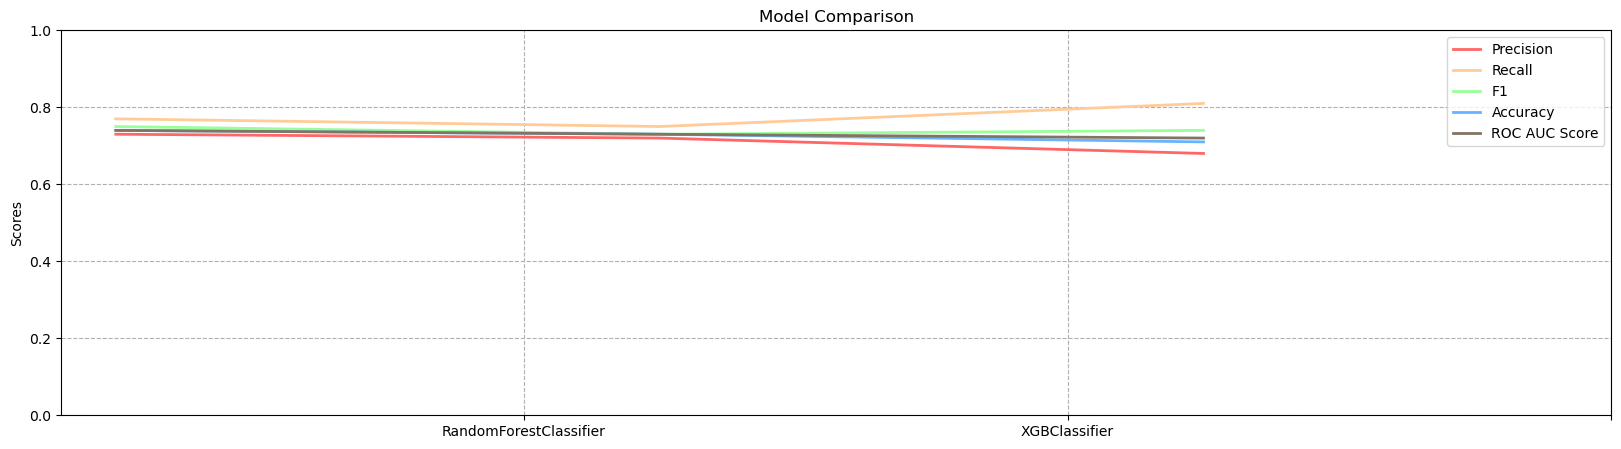

In [29]:
compare_data = pd.DataFrame(AllScores, columns=["Model", 'Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC Score', "True Negative", "False Positive", "False Negative", "True Positive"]).round(2)

fig = plt.subplots(figsize=(20,5), sharex=True)
x = np.arange(len(compare_data['Model']))
plt.grid(True, linestyle='--')
plt.plot(compare_data['Model'], compare_data['Precision'], color='#ff6666', label='Precision', linewidth=2)
plt.plot(compare_data['Model'] , compare_data['Recall'], color='#ffcc99', label='Recall', linewidth=2)
plt.plot(compare_data['Model'], compare_data['F1'], color='#99ff99', label='F1', linewidth=2)
plt.plot(compare_data['Model'], compare_data['Accuracy'], color='#66b3ff', label='Accuracy', linewidth=2)
plt.plot(compare_data['Model'], compare_data['ROC AUC Score'], color='#827462', label='ROC AUC Score', linewidth=2)
plt.legend()
plt.ylabel('Scores')
plt.ylim(0,1)
plt.xticks(x + 0.5 + 0.5/2)
plt.title('Model Comparison')

# Advance customized model

Spliting the dataset

In [22]:
from sklearn.model_selection import train_test_split
df_train, df_test_val, y_train, y_test_val = train_test_split(dataPreprocessed['processedText'], dataPreprocessed.target, test_size = 0.3, random_state = 0)
df_test, df_val, y_test, y_val = train_test_split(df_test_val, y_test_val, test_size = 0.5, random_state = 0)

Creating token from text

In [23]:
textToken = [_text.split() for _text in dataPreprocessed['processedText']]

### Creating embedding model
Word2vec 

In [24]:
from gensim.models import Word2Vec
import gensim.downloader as api
Embedding_dimensions = 300

#Loading a pretrained model on tweets

# model_pre_w2v = api.load("glove-twitter-100")


w2v_model = Word2Vec(vector_size=Embedding_dimensions, # Dimensionality of word embeddings
                      window=6,                         # Context window for words during training
                      min_count=3,                      # Minimun threshold of word frequency
                      workers=8,
                      epochs=20)                        # Number of epochs training over corpus
gen_vocab_w2v = w2v_model.build_vocab(textToken)
# w2v_model.build_vocab([list(model_pre_w2v.vocab.keys())], update=True)
# w2v_model.intersect_word2vec_format("glove.6B.300d.txt", binary=False, lockf=1.0)
# w2v_model.train(textToken, total_examples=gen_vocab_w2v, epochs=w2v_model.iter)

Fasttext

In [25]:
from gensim.models import FastText


fasttext_model = FastText(vector_size=Embedding_dimensions, # Dimensionality of word embeddings
                      window=6,                             # Context window for words during training
                      min_count=3,                          # Minimun threshold of word frequency
                      workers=8,
                      epochs=20)                            # Number of epochs training over corpus
fasttext_model.build_vocab(textToken)

### Tokenizing and Padding 

**Tokenization** is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either word, character, and subword (n-gram characters).

**Padding** is the process by which we can add padding tokens at the start or end of a sentence to increase it's length upto the required size. If required, we can also drop some words to reduce to the specified length.

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# creating fix test length for padding
input_length = 150

# tokenizing the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataPreprocessed['processedText'])

# creating vocabulary
vocab_size = len(tokenizer.word_index) + 1
print("Total vocabulary", vocab_size)

# Tokenizing and padding the train and test dataset
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train), maxlen=input_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test), maxlen=input_length)

Total vocabulary 46278


In [27]:
embedding_vector = {}
f = open('glove.6B/glove.6B.300d.txt')
for line in f:
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

**Embedding Layer** - Generates Embedding Vector for each input sequence.

In [28]:
from keras.layers import Embedding

def createEmbeddingMatrix(model, modelName):
  embedding_matrix = np.zeros((vocab_size, Embedding_dimensions))
  for word, i in tokenizer.word_index.items():
    if modelName == 'Glove':
      embedding_value = embedding_vector.get(word)
      if embedding_value is not None:
          embedding_matrix[i] = embedding_value
    else:
      if word in model.wv:
        embedding_matrix[i] = model.wv[word]
  print("Embedded matrix shape for ", modelName ,":", embedding_matrix.shape)
  return embedding_matrix

In [29]:
embedding_layer_word2vec = Embedding(vocab_size, Embedding_dimensions, weights=[createEmbeddingMatrix(w2v_model, "Word2vec")], input_length=input_length, trainable=False)
embedding_layer_fasttext = Embedding(vocab_size, Embedding_dimensions, weights=[createEmbeddingMatrix(fasttext_model, "FastText")], input_length=input_length, trainable=False)
embedding_layer_glove = Embedding(vocab_size, Embedding_dimensions, weights=[createEmbeddingMatrix(embedding_vector, 'Glove')], input_length=input_length, trainable=False)

Embedded matrix shape for  Word2vec : (46278, 300)

Embedded matrix shape for  FastText : (46278, 300)

Embedded matrix shape for  Glove : (46278, 300)


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Model

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction.

## Recurrent Neural Networks (RNN)

In [31]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense  , Conv1D, GlobalMaxPool1D, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [32]:
callbacks = [ReduceLROnPlateau(factor=0.1,min_lr = 0.001, monitor = 'val_loss',verbose = 1),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [41]:
evaluationScore = []
# Defining LSTM model
def simpleLSTM(embedded_layer):
	lstm_model = Sequential(name="LSTM_Model")
	lstm_model.add(embedded_layer)
	lstm_model.add(LSTM(128,activation='relu', return_sequences=True))
	lstm_model.add(Dense(1, activation='sigmoid'))

	# Printing Model Summary
	print(lstm_model.summary())

	# Compiling the model
	lstm_model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

	# Training the model
	history = lstm_model.fit(x_train, y_train,
							batch_size=512,
							epochs=10,
							verbose=1,
							validation_split=0.1,
							callbacks=callbacks)
	print("LSTM model Score---> ", lstm_model.evaluate(x_test, y_test, verbose=0))
	return (lstm_model, history)


In [42]:
def lossAndAccuracy(hist, title):
    acc,  val_acc  = hist.history['accuracy'], hist.history['val_accuracy']
    loss, val_loss = hist.history['loss'], hist.history['val_loss']
    epochs = range(len(acc))

    plt.suptitle(title)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

In [43]:
# from sklearn.metrics import confusion_matrix, classification_report

# def ConfusionMatrix(model, x_test, y_test, title):
#     pred = model.predict(x_test)
#     y_pred = pd.Series([val[0][0] for val in np.where(pred>=0.5, 1, 0)])
#     # Compute and plot the Confusion matrix
#     cf_matrix = confusion_matrix(y_test, y_pred)

#     categories  = ['Negative','Positive']
#     group_names = ['True Neg','False Pos', 'False Neg','True Pos']
#     group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

#     labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     print(classification_report(y_test, y_pred))
#     sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
#                 xticklabels = categories, yticklabels = categories)

#     plt.xlabel("Predicted values", fontdict = {'size':14})
#     plt.ylabel("Actual values"   , fontdict = {'size':14})
#     plt.title (title, fontdict = {'size':16})

#### Simple LSTM with word2vec embeddings

In [44]:
simpleLSTMWord2vec = simpleLSTM(embedding_layer_word2vec)


Model: "LSTM_Model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, 150, 300)          13883400  

                                                                 

 lstm (LSTM)                 (None, 150, 128)          219648    

                                                                 

 dense (Dense)               (None, 150, 1)            129       

                                                                 


Total params: 14,103,177

Trainable params: 219,777

Non-trainable params: 13,883,400

_________________________________________________________________

None

Epoch 1/10

206/206 [==============================] - 126s 600ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4985 - lr: 0.0010

Epoch 2/10

206/206 [==============================] - 128s 622ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.

<Figure size 640x480 with 0 Axes>

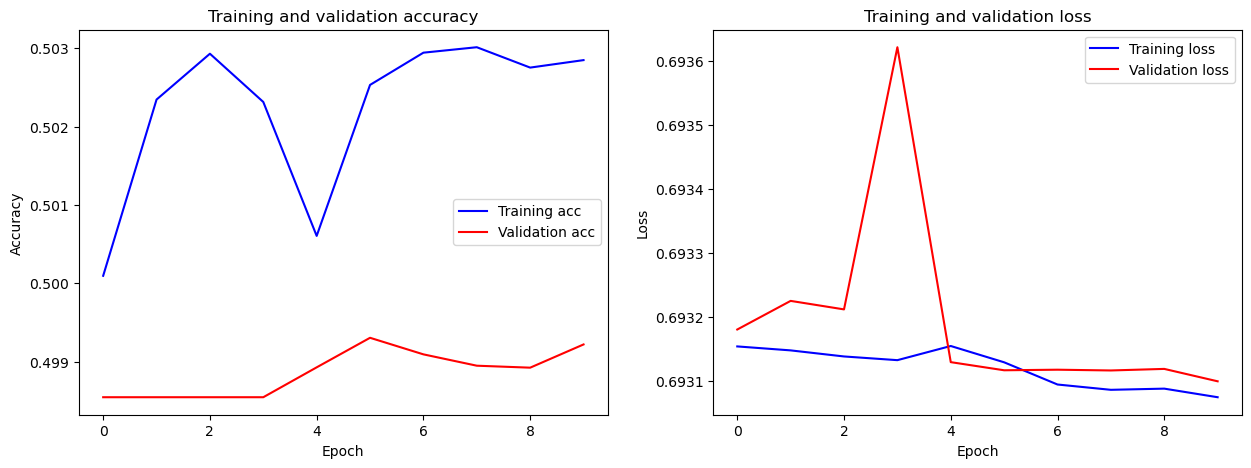

In [45]:
lossAndAccuracy(simpleLSTMWord2vec[1], 'Simple LSTM with Word2vec embedding model')

#### Simple LSTM with Fasttext embeddings

In [46]:
simpleLSTMFastText = simpleLSTM(embedding_layer_fasttext)


Model: "LSTM_Model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, 150, 300)          13883400  

                                                                 

 lstm_1 (LSTM)               (None, 150, 128)          219648    

                                                                 

 dense_1 (Dense)             (None, 150, 1)            129       

                                                                 


Total params: 14,103,177

Trainable params: 219,777

Non-trainable params: 13,883,400

_________________________________________________________________

None

Epoch 1/10

206/206 [==============================] - 128s 613ms/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4985 - lr: 0.0010

Epoch 2/10

206/206 [==============================] - 126s 612ms/step - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.

<Figure size 640x480 with 0 Axes>

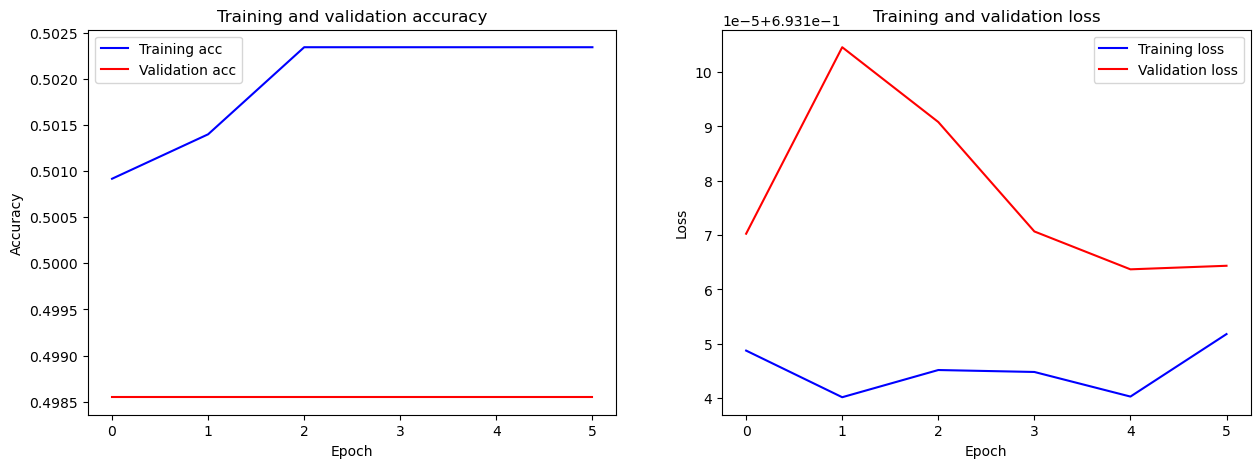

In [47]:
lossAndAccuracy(simpleLSTMFastText[1], 'Simple LSTM with FastText embedding model')

#### Simple LSTM with GloVe embeddings

In [48]:
simpleLSTMGlove = simpleLSTM(embedding_layer_glove)


Model: "LSTM_Model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_2 (Embedding)     (None, 150, 300)          13883400  

                                                                 

 lstm_2 (LSTM)               (None, 150, 128)          219648    

                                                                 

 dense_2 (Dense)             (None, 150, 1)            129       

                                                                 


Total params: 14,103,177

Trainable params: 219,777

Non-trainable params: 13,883,400

_________________________________________________________________

None

Epoch 1/10

206/206 [==============================] - 130s 623ms/step - loss: 0.6901 - accuracy: 0.5075 - val_loss: 0.6893 - val_accuracy: 0.5056 - lr: 0.0010

Epoch 2/10

206/206 [==============================] - 127s 618ms/step - loss: 0.6891 - accuracy: 0.5091 - val_loss: 0.

<Figure size 640x480 with 0 Axes>

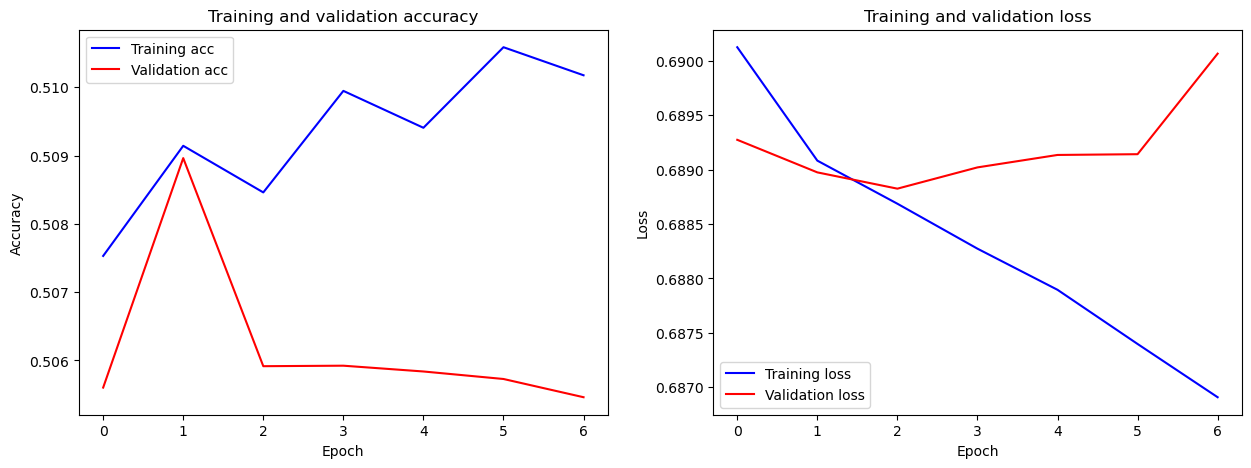

In [49]:
lossAndAccuracy(simpleLSTMGlove[1], 'Simple LSTM with Glove embedding model')

### Bidirectional LSTM 

In [50]:
# Defining Bidirectional LSTM model
def bilstmModel(embedding_layer):
  bi_lstm_model = Sequential(name="Bidirectional_LSTM")
  bi_lstm_model.add(embedding_layer)
  bi_lstm_model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True)))
  bi_lstm_model.add(Dense(1, activation='sigmoid'))

  # Printing model summary
  print(bi_lstm_model.summary())

  # Compiling model summary
  bi_lstm_model.compile(
  loss="binary_crossentropy",
  optimizer='adam',
  metrics=['accuracy']
  )

  # Training the model
  history = bi_lstm_model.fit(x_train, y_train,
                              batch_size=512,
                              epochs=10,
                              verbose=1,
                              validation_split=0.1,
                              callbacks=callbacks)
  print("Bi-directional LSTM model Score---> ", bi_lstm_model.evaluate(x_test, y_test, verbose=0))
  return (bi_lstm_model, history)

#### Bidirectional LSTM with word2vec embeddings

In [51]:
BiLSTMWord2vec = bilstmModel(embedding_layer_word2vec)




Model: "Bidirectional_LSTM"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, 150, 300)          13883400  

                                                                 

 bidirectional (Bidirectiona  (None, 150, 256)         439296    

 l)                                                              

                                                                 

 dense_3 (Dense)             (None, 150, 1)            257       

                                                                 


Total params: 14,322,953

Trainable params: 439,553

Non-trainable params: 13,883,400

_________________________________________________________________

None

Epoch 1/10

206/206 [==============================] - 224s 1s/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.4987 - lr: 0.0010

Epoch 2/10

206/206 [========================

<Figure size 640x480 with 0 Axes>

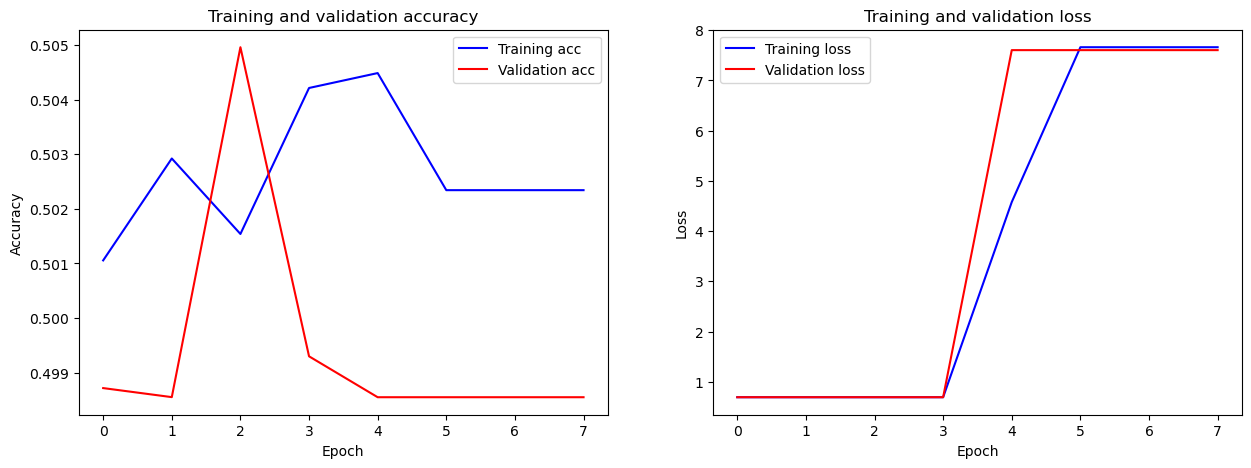

In [52]:
lossAndAccuracy(BiLSTMWord2vec[1], 'Bidirectional LSTM with Word2vec embedding model')

#### Bidirectional LSTM with Fasttext embeddings

In [53]:
biLSTMFastText = bilstmModel(embedding_layer_fasttext)




Model: "Bidirectional_LSTM"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, 150, 300)          13883400  

                                                                 

 bidirectional_1 (Bidirectio  (None, 150, 256)         439296    

 nal)                                                            

                                                                 

 dense_4 (Dense)             (None, 150, 1)            257       

                                                                 


Total params: 14,322,953

Trainable params: 439,553

Non-trainable params: 13,883,400

_________________________________________________________________

None

Epoch 1/10

206/206 [==============================] - 221s 1s/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4985 - lr: 0.0010

Epoch 2/10

206/206 [========================

<Figure size 640x480 with 0 Axes>

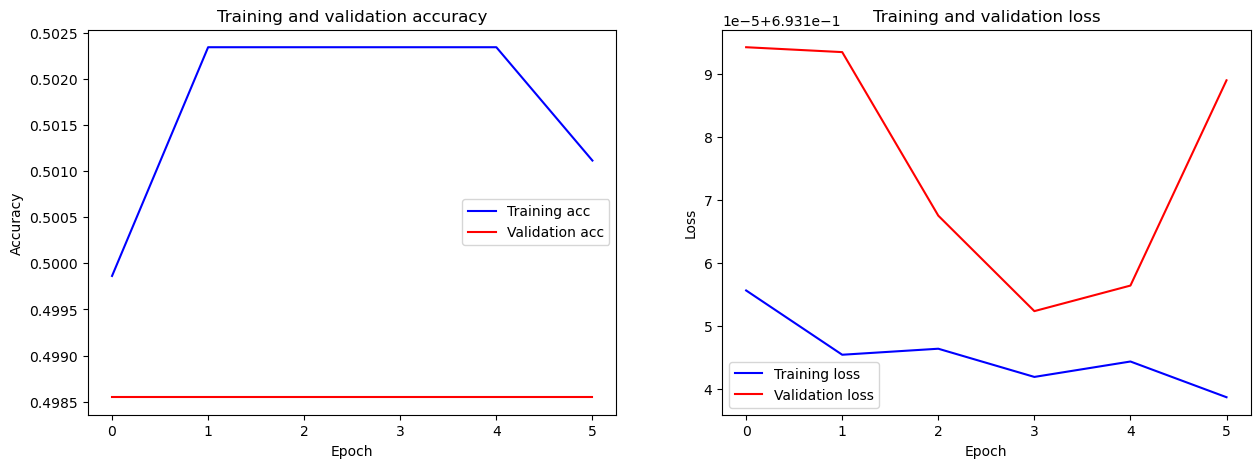

In [54]:
lossAndAccuracy(biLSTMFastText[1], 'Bidirectional LSTM with Fasttext embedding model')

#### Bidirectional LSTM with Glove embeddings

In [55]:
biLSTMGlove = bilstmModel(embedding_layer_glove)




Model: "Bidirectional_LSTM"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_2 (Embedding)     (None, 150, 300)          13883400  

                                                                 

 bidirectional_2 (Bidirectio  (None, 150, 256)         439296    

 nal)                                                            

                                                                 

 dense_5 (Dense)             (None, 150, 1)            257       

                                                                 


Total params: 14,322,953

Trainable params: 439,553

Non-trainable params: 13,883,400

_________________________________________________________________

None

Epoch 1/10

206/206 [==============================] - 238s 1s/step - loss: 0.6530 - accuracy: 0.6266 - val_loss: 0.6594 - val_accuracy: 0.6396 - lr: 0.0010

Epoch 2/10

206/206 [========================

<Figure size 640x480 with 0 Axes>

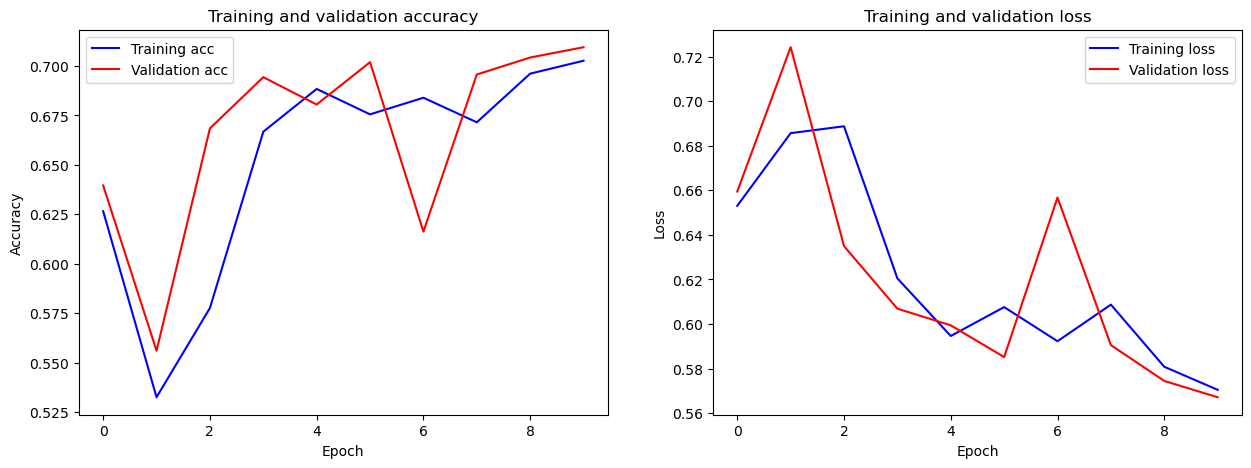

In [56]:
lossAndAccuracy(biLSTMGlove[1], 'Bidirectional LSTM with Glove embedding model')

## Results 

Score suggests that bidirectional LSTM with glove embeddings is performaing really well, we will try to imporive the performace by tuning the hyperparameters.

In [ ]:
callbacks = [ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1),
             EarlyStopping(monitor="val_loss", patience=60, verbose=1, mode="min", restore_best_weights=True)]

In [ ]:
# Defining Bidirectional LSTM model
def bilstmModel(embedding_layer):
  bi_lstm_model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(256, return_sequences=True)),
        Dropout(0.5),
        BatchNormalization(),
        Bidirectional(LSTM(256, return_sequences=True)),
        Dropout(0.5),
        BatchNormalization(),
        SpatialDropout1D(0.4),
        Conv1D(256, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(1, activation='sigmoid'),
        ],
    name="Sentiment_Model")

  # Printing model summary
  print(bi_lstm_model.summary())

  # Compiling model summary
  bi_lstm_model.compile(loss = 'binary_crossentropy',
#  optimizer = Adam(learning_rate = 0.0001),
  optimizer = 'adam',
  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
  )

  # Training the model
  history4 = bi_lstm_model.fit(x_train, y_train,
                batch_size=256,
                epochs=10,
                verbose=1,
                validation_data=(x_val, y_val),
                callbacks=callbacks)

  # Printing model score on test data
  print()
  print("Bidirectional LSTM model Score---> ", bi_lstm_model.evaluate(x_test, y_test, batch_size=256, verbose=0))
  return (bi_lstm_model, history4)

In [ ]:
bilstm_glove = bilstmModel(embedding_layer_glove)

In [ ]:
pd.DataFrame(bilstm_glove[1].history).plot(figsize=(10,7))
plt.show()

In [ ]:
pred = bilstm_glove[0].predict(x_test)
y_pred = pd.Series([val[0] for val in np.where(pred>=0.5, 1, 0)])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test, title="checking"):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    print(classification_report(y_test, y_pred))
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14})
    plt.ylabel("Actual values"   , fontdict = {'size':14})
    plt.title (title, fontdict = {'size':16})

In [ ]:
#@title Default title text
ConfusionMatrix(y_pred, y_test)